In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-07 16:42:37.537132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-07 16:42:37.537183: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.1)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="chisq", threshold=0.5,
                                  noise_distribution="chisq", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:33280, :], y[:33280]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

scan_schedule = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 3*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 3*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 3*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 3*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 3*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 3*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in scan_schedule:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/119


2022-05-07 16:42:41.825087: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-07 16:42:41.825135: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-07 16:42:41.825163: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-07 16:42:41.825419: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


130/130 [==============================] - 3s 10ms/step - loss: 0.7413 - accuracy: 0.4986 - auc: 0.4293 - val_loss: 0.7140 - val_accuracy: 0.4883 - val_auc: 0.4186
Epoch 2/119
130/130 [==============================] - 1s 7ms/step - loss: 0.7128 - accuracy: 0.4968 - auc: 0.4818 - val_loss: 0.6961 - val_accuracy: 0.4891 - val_auc: 0.5103
Epoch 3/119
130/130 [==============================] - 1s 6ms/step - loss: 0.7000 - accuracy: 0.4963 - auc: 0.5230 - val_loss: 0.6870 - val_accuracy: 0.5017 - val_auc: 0.5840
Epoch 4/119
130/130 [==============================] - 1s 4ms/step - loss: 0.6927 - accuracy: 0.5002 - auc: 0.5567 - val_loss: 0.6816 - val_accuracy: 0.5081 - val_auc: 0.6369
Epoch 5/119
130/130 [==============================] - 1s 5ms/step - loss: 0.6886 - accuracy: 0.5039 - auc: 0.5799 - val_loss: 0.6780 - val_accuracy: 0.5117 - val_auc: 0.6724
Epoch 6/119
130/130 [==============================] - 1s 6ms/step - loss: 0.6857 - accuracy: 0.5088 - auc: 0.5927 - val_loss: 0.6752 - 

Epoch 48/119
130/130 [==============================] - 1s 4ms/step - loss: 0.5361 - accuracy: 0.7489 - auc: 0.8391 - val_loss: 0.4952 - val_accuracy: 0.8705 - val_auc: 0.9522
Epoch 49/119
130/130 [==============================] - 1s 4ms/step - loss: 0.5293 - accuracy: 0.7533 - auc: 0.8437 - val_loss: 0.4870 - val_accuracy: 0.8735 - val_auc: 0.9541
Epoch 50/119
130/130 [==============================] - 1s 4ms/step - loss: 0.5241 - accuracy: 0.7572 - auc: 0.8459 - val_loss: 0.4790 - val_accuracy: 0.8752 - val_auc: 0.9560
Epoch 51/119
130/130 [==============================] - 1s 4ms/step - loss: 0.5182 - accuracy: 0.7617 - auc: 0.8501 - val_loss: 0.4724 - val_accuracy: 0.8762 - val_auc: 0.9577
Epoch 52/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5140 - accuracy: 0.7660 - auc: 0.8522 - val_loss: 0.4667 - val_accuracy: 0.8758 - val_auc: 0.9594
Epoch 53/119
130/130 [==============================] - 1s 4ms/step - loss: 0.5088 - accuracy: 0.7670 - auc: 0.8542 - va

130/130 [==============================] - 1s 5ms/step - loss: 0.3588 - accuracy: 0.8367 - auc: 0.9222 - val_loss: 0.2892 - val_accuracy: 0.8838 - val_auc: 0.9871
Epoch 95/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3578 - accuracy: 0.8365 - auc: 0.9224 - val_loss: 0.2909 - val_accuracy: 0.8796 - val_auc: 0.9873
Epoch 96/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3563 - accuracy: 0.8386 - auc: 0.9231 - val_loss: 0.2886 - val_accuracy: 0.8806 - val_auc: 0.9874
Epoch 97/119
130/130 [==============================] - 1s 6ms/step - loss: 0.3555 - accuracy: 0.8417 - auc: 0.9233 - val_loss: 0.2879 - val_accuracy: 0.8798 - val_auc: 0.9876
Epoch 98/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3475 - accuracy: 0.8438 - auc: 0.9276 - val_loss: 0.2853 - val_accuracy: 0.8803 - val_auc: 0.9877
Epoch 99/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3535 - accuracy: 0.8412 - auc: 0.9239 - val_loss: 0.284

130/130 [==============================] - 1s 6ms/step - loss: 0.5864 - accuracy: 0.7120 - auc: 0.8087 - val_loss: 0.5613 - val_accuracy: 0.8427 - val_auc: 0.9275
Epoch 21/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5766 - accuracy: 0.7221 - auc: 0.8212 - val_loss: 0.5517 - val_accuracy: 0.8471 - val_auc: 0.9309
Epoch 22/119
130/130 [==============================] - 1s 6ms/step - loss: 0.5703 - accuracy: 0.7246 - auc: 0.8228 - val_loss: 0.5426 - val_accuracy: 0.8502 - val_auc: 0.9343
Epoch 23/119
130/130 [==============================] - 1s 6ms/step - loss: 0.5631 - accuracy: 0.7334 - auc: 0.8277 - val_loss: 0.5338 - val_accuracy: 0.8550 - val_auc: 0.9379
Epoch 24/119
130/130 [==============================] - 1s 6ms/step - loss: 0.5521 - accuracy: 0.7435 - auc: 0.8388 - val_loss: 0.5236 - val_accuracy: 0.8594 - val_auc: 0.9414
Epoch 25/119
130/130 [==============================] - 1s 9ms/step - loss: 0.5456 - accuracy: 0.7479 - auc: 0.8409 - val_loss: 0.513

130/130 [==============================] - 1s 8ms/step - loss: 0.3451 - accuracy: 0.8459 - auc: 0.9278 - val_loss: 0.2764 - val_accuracy: 0.8887 - val_auc: 0.9875
Epoch 67/119
130/130 [==============================] - 1s 6ms/step - loss: 0.3419 - accuracy: 0.8468 - auc: 0.9293 - val_loss: 0.2751 - val_accuracy: 0.8875 - val_auc: 0.9877
Epoch 68/119
130/130 [==============================] - 1s 7ms/step - loss: 0.3422 - accuracy: 0.8460 - auc: 0.9289 - val_loss: 0.2745 - val_accuracy: 0.8860 - val_auc: 0.9878
Epoch 69/119
130/130 [==============================] - 1s 7ms/step - loss: 0.3385 - accuracy: 0.8469 - auc: 0.9305 - val_loss: 0.2696 - val_accuracy: 0.8902 - val_auc: 0.9880
Epoch 70/119
130/130 [==============================] - 1s 6ms/step - loss: 0.3352 - accuracy: 0.8482 - auc: 0.9321 - val_loss: 0.2735 - val_accuracy: 0.8845 - val_auc: 0.9882
Epoch 71/119
130/130 [==============================] - 1s 8ms/step - loss: 0.3360 - accuracy: 0.8505 - auc: 0.9311 - val_loss: 0.270

130/130 [==============================] - 1s 7ms/step - loss: 0.2911 - accuracy: 0.8715 - auc: 0.9483 - val_loss: 0.2763 - val_accuracy: 0.8591 - val_auc: 0.9906
Epoch 113/119
130/130 [==============================] - 1s 8ms/step - loss: 0.2880 - accuracy: 0.8724 - auc: 0.9496 - val_loss: 0.2707 - val_accuracy: 0.8630 - val_auc: 0.9906
Epoch 114/119
130/130 [==============================] - 1s 6ms/step - loss: 0.2888 - accuracy: 0.8716 - auc: 0.9488 - val_loss: 0.2817 - val_accuracy: 0.8542 - val_auc: 0.9906
Epoch 115/119
130/130 [==============================] - 1s 7ms/step - loss: 0.2880 - accuracy: 0.8706 - auc: 0.9492 - val_loss: 0.2783 - val_accuracy: 0.8568 - val_auc: 0.9906
Epoch 116/119
130/130 [==============================] - 1s 7ms/step - loss: 0.2900 - accuracy: 0.8711 - auc: 0.9485 - val_loss: 0.2806 - val_accuracy: 0.8551 - val_auc: 0.9906
Epoch 117/119
130/130 [==============================] - 1s 6ms/step - loss: 0.2866 - accuracy: 0.8727 - auc: 0.9497 - val_loss: 

130/130 [==============================] - 1s 7ms/step - loss: 0.4025 - accuracy: 0.8202 - auc: 0.9072 - val_loss: 0.3364 - val_accuracy: 0.8963 - val_auc: 0.9799
Epoch 39/119
130/130 [==============================] - 1s 7ms/step - loss: 0.4002 - accuracy: 0.8206 - auc: 0.9076 - val_loss: 0.3340 - val_accuracy: 0.8898 - val_auc: 0.9806
Epoch 40/119
130/130 [==============================] - 1s 7ms/step - loss: 0.3948 - accuracy: 0.8233 - auc: 0.9094 - val_loss: 0.3290 - val_accuracy: 0.8887 - val_auc: 0.9812
Epoch 41/119
130/130 [==============================] - 1s 7ms/step - loss: 0.3879 - accuracy: 0.8264 - auc: 0.9129 - val_loss: 0.3232 - val_accuracy: 0.8882 - val_auc: 0.9819
Epoch 42/119
130/130 [==============================] - 1s 7ms/step - loss: 0.3812 - accuracy: 0.8289 - auc: 0.9155 - val_loss: 0.3156 - val_accuracy: 0.8919 - val_auc: 0.9826
Epoch 43/119
130/130 [==============================] - 1s 7ms/step - loss: 0.3746 - accuracy: 0.8337 - auc: 0.9185 - val_loss: 0.310

130/130 [==============================] - 1s 5ms/step - loss: 0.2879 - accuracy: 0.8718 - auc: 0.9496 - val_loss: 0.2727 - val_accuracy: 0.8615 - val_auc: 0.9900
Epoch 85/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2868 - accuracy: 0.8735 - auc: 0.9499 - val_loss: 0.2743 - val_accuracy: 0.8605 - val_auc: 0.9900
Epoch 86/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2881 - accuracy: 0.8711 - auc: 0.9493 - val_loss: 0.2820 - val_accuracy: 0.8553 - val_auc: 0.9899
Epoch 87/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2874 - accuracy: 0.8719 - auc: 0.9495 - val_loss: 0.2773 - val_accuracy: 0.8582 - val_auc: 0.9900
Epoch 88/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2883 - accuracy: 0.8708 - auc: 0.9491 - val_loss: 0.2787 - val_accuracy: 0.8572 - val_auc: 0.9900
Epoch 89/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2864 - accuracy: 0.8714 - auc: 0.9500 - val_loss: 0.287

130/130 [==============================] - 1s 5ms/step - loss: 0.6603 - accuracy: 0.5833 - auc: 0.6823 - val_loss: 0.6512 - val_accuracy: 0.6613 - val_auc: 0.8180
Epoch 11/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6573 - accuracy: 0.5947 - auc: 0.6899 - val_loss: 0.6478 - val_accuracy: 0.6866 - val_auc: 0.8279
Epoch 12/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6536 - accuracy: 0.6054 - auc: 0.6999 - val_loss: 0.6442 - val_accuracy: 0.7055 - val_auc: 0.8378
Epoch 13/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6490 - accuracy: 0.6182 - auc: 0.7134 - val_loss: 0.6406 - val_accuracy: 0.7217 - val_auc: 0.8456
Epoch 14/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6470 - accuracy: 0.6228 - auc: 0.7148 - val_loss: 0.6371 - val_accuracy: 0.7357 - val_auc: 0.8527
Epoch 15/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6415 - accuracy: 0.6361 - auc: 0.7297 - val_loss: 0.633

130/130 [==============================] - 1s 5ms/step - loss: 0.4740 - accuracy: 0.7887 - auc: 0.8760 - val_loss: 0.4368 - val_accuracy: 0.8620 - val_auc: 0.9715
Epoch 57/249
130/130 [==============================] - 1s 6ms/step - loss: 0.4705 - accuracy: 0.7906 - auc: 0.8776 - val_loss: 0.4318 - val_accuracy: 0.8623 - val_auc: 0.9723
Epoch 58/249
130/130 [==============================] - 1s 6ms/step - loss: 0.4677 - accuracy: 0.7896 - auc: 0.8777 - val_loss: 0.4279 - val_accuracy: 0.8601 - val_auc: 0.9731
Epoch 59/249
130/130 [==============================] - 0s 4ms/step - loss: 0.4638 - accuracy: 0.7924 - auc: 0.8801 - val_loss: 0.4233 - val_accuracy: 0.8605 - val_auc: 0.9739
Epoch 60/249
130/130 [==============================] - 0s 4ms/step - loss: 0.4579 - accuracy: 0.7961 - auc: 0.8835 - val_loss: 0.4186 - val_accuracy: 0.8608 - val_auc: 0.9747
Epoch 61/249
130/130 [==============================] - 1s 5ms/step - loss: 0.4557 - accuracy: 0.7961 - auc: 0.8834 - val_loss: 0.413

130/130 [==============================] - 1s 6ms/step - loss: 0.3552 - accuracy: 0.8390 - auc: 0.9257 - val_loss: 0.2905 - val_accuracy: 0.8830 - val_auc: 0.9884
Epoch 103/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3555 - accuracy: 0.8397 - auc: 0.9252 - val_loss: 0.2921 - val_accuracy: 0.8799 - val_auc: 0.9884
Epoch 104/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3554 - accuracy: 0.8413 - auc: 0.9250 - val_loss: 0.2855 - val_accuracy: 0.8859 - val_auc: 0.9885
Epoch 105/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3528 - accuracy: 0.8414 - auc: 0.9262 - val_loss: 0.2882 - val_accuracy: 0.8813 - val_auc: 0.9886
Epoch 106/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3474 - accuracy: 0.8459 - auc: 0.9289 - val_loss: 0.2849 - val_accuracy: 0.8842 - val_auc: 0.9887
Epoch 107/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3540 - accuracy: 0.8407 - auc: 0.9256 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.3106 - accuracy: 0.8621 - auc: 0.9428 - val_loss: 0.2582 - val_accuracy: 0.8829 - val_auc: 0.9902
Epoch 149/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3133 - accuracy: 0.8606 - auc: 0.9419 - val_loss: 0.2648 - val_accuracy: 0.8773 - val_auc: 0.9902
Epoch 150/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3119 - accuracy: 0.8627 - auc: 0.9424 - val_loss: 0.2638 - val_accuracy: 0.8774 - val_auc: 0.9901
Epoch 151/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3097 - accuracy: 0.8614 - auc: 0.9434 - val_loss: 0.2578 - val_accuracy: 0.8826 - val_auc: 0.9902
Epoch 152/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3105 - accuracy: 0.8627 - auc: 0.9427 - val_loss: 0.2589 - val_accuracy: 0.8815 - val_auc: 0.9903
Epoch 153/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3129 - accuracy: 0.8613 - auc: 0.9419 - val_loss: 

130/130 [==============================] - 1s 6ms/step - loss: 0.2894 - accuracy: 0.8748 - auc: 0.9502 - val_loss: 0.2590 - val_accuracy: 0.8754 - val_auc: 0.9910
Epoch 195/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2872 - accuracy: 0.8733 - auc: 0.9514 - val_loss: 0.2571 - val_accuracy: 0.8766 - val_auc: 0.9911
Epoch 196/249
130/130 [==============================] - 1s 6ms/step - loss: 0.2919 - accuracy: 0.8697 - auc: 0.9491 - val_loss: 0.2607 - val_accuracy: 0.8733 - val_auc: 0.9911
Epoch 197/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2913 - accuracy: 0.8726 - auc: 0.9496 - val_loss: 0.2581 - val_accuracy: 0.8759 - val_auc: 0.9911
Epoch 198/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2889 - accuracy: 0.8715 - auc: 0.9505 - val_loss: 0.2589 - val_accuracy: 0.8752 - val_auc: 0.9911
Epoch 199/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2891 - accuracy: 0.8739 - auc: 0.9502 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.2716 - accuracy: 0.8825 - auc: 0.9560 - val_loss: 0.2633 - val_accuracy: 0.8691 - val_auc: 0.9918
Epoch 241/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2754 - accuracy: 0.8798 - auc: 0.9545 - val_loss: 0.2671 - val_accuracy: 0.8666 - val_auc: 0.9918
Epoch 242/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2740 - accuracy: 0.8792 - auc: 0.9553 - val_loss: 0.2681 - val_accuracy: 0.8658 - val_auc: 0.9918
Epoch 243/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2696 - accuracy: 0.8816 - auc: 0.9570 - val_loss: 0.2661 - val_accuracy: 0.8673 - val_auc: 0.9918
Epoch 244/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2760 - accuracy: 0.8786 - auc: 0.9546 - val_loss: 0.2645 - val_accuracy: 0.8677 - val_auc: 0.9919
Epoch 245/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2700 - accuracy: 0.8809 - auc: 0.9564 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.5271 - accuracy: 0.7618 - auc: 0.8479 - val_loss: 0.4992 - val_accuracy: 0.8601 - val_auc: 0.9548
Epoch 37/249
130/130 [==============================] - 1s 5ms/step - loss: 0.5217 - accuracy: 0.7664 - auc: 0.8512 - val_loss: 0.4930 - val_accuracy: 0.8611 - val_auc: 0.9565
Epoch 38/249
130/130 [==============================] - 1s 5ms/step - loss: 0.5150 - accuracy: 0.7684 - auc: 0.8560 - val_loss: 0.4867 - val_accuracy: 0.8610 - val_auc: 0.9582
Epoch 39/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5096 - accuracy: 0.7724 - auc: 0.8588 - val_loss: 0.4794 - val_accuracy: 0.8636 - val_auc: 0.9598
Epoch 40/249
130/130 [==============================] - 1s 5ms/step - loss: 0.5057 - accuracy: 0.7735 - auc: 0.8598 - val_loss: 0.4722 - val_accuracy: 0.8666 - val_auc: 0.9614
Epoch 41/249
130/130 [==============================] - 1s 6ms/step - loss: 0.4995 - accuracy: 0.7758 - auc: 0.8629 - val_loss: 0.465

130/130 [==============================] - 1s 4ms/step - loss: 0.3581 - accuracy: 0.8389 - auc: 0.9239 - val_loss: 0.2728 - val_accuracy: 0.9053 - val_auc: 0.9884
Epoch 83/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3547 - accuracy: 0.8423 - auc: 0.9261 - val_loss: 0.2691 - val_accuracy: 0.9071 - val_auc: 0.9884
Epoch 84/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3525 - accuracy: 0.8418 - auc: 0.9266 - val_loss: 0.2688 - val_accuracy: 0.9056 - val_auc: 0.9886
Epoch 85/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3477 - accuracy: 0.8452 - auc: 0.9291 - val_loss: 0.2639 - val_accuracy: 0.9085 - val_auc: 0.9886
Epoch 86/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3506 - accuracy: 0.8417 - auc: 0.9271 - val_loss: 0.2689 - val_accuracy: 0.9009 - val_auc: 0.9886
Epoch 87/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3473 - accuracy: 0.8441 - auc: 0.9287 - val_loss: 0.262

130/130 [==============================] - 1s 6ms/step - loss: 0.3090 - accuracy: 0.8633 - auc: 0.9434 - val_loss: 0.2341 - val_accuracy: 0.9017 - val_auc: 0.9900
Epoch 129/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3092 - accuracy: 0.8620 - auc: 0.9436 - val_loss: 0.2291 - val_accuracy: 0.9061 - val_auc: 0.9900
Epoch 130/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3028 - accuracy: 0.8656 - auc: 0.9461 - val_loss: 0.2312 - val_accuracy: 0.9031 - val_auc: 0.9901
Epoch 131/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3137 - accuracy: 0.8598 - auc: 0.9414 - val_loss: 0.2394 - val_accuracy: 0.8961 - val_auc: 0.9900
Epoch 132/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3023 - accuracy: 0.8651 - auc: 0.9459 - val_loss: 0.2322 - val_accuracy: 0.9017 - val_auc: 0.9900
Epoch 133/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3043 - accuracy: 0.8663 - auc: 0.9450 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.2847 - accuracy: 0.8738 - auc: 0.9520 - val_loss: 0.2311 - val_accuracy: 0.8937 - val_auc: 0.9913
Epoch 175/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2864 - accuracy: 0.8751 - auc: 0.9512 - val_loss: 0.2299 - val_accuracy: 0.8943 - val_auc: 0.9913
Epoch 176/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2819 - accuracy: 0.8742 - auc: 0.9529 - val_loss: 0.2323 - val_accuracy: 0.8928 - val_auc: 0.9912
Epoch 177/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2858 - accuracy: 0.8745 - auc: 0.9513 - val_loss: 0.2336 - val_accuracy: 0.8923 - val_auc: 0.9912
Epoch 178/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2781 - accuracy: 0.8791 - auc: 0.9542 - val_loss: 0.2331 - val_accuracy: 0.8924 - val_auc: 0.9913
Epoch 179/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2804 - accuracy: 0.8789 - auc: 0.9533 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.2701 - accuracy: 0.8832 - auc: 0.9561 - val_loss: 0.2379 - val_accuracy: 0.8842 - val_auc: 0.9920
Epoch 221/249
130/130 [==============================] - 1s 6ms/step - loss: 0.2637 - accuracy: 0.8873 - auc: 0.9584 - val_loss: 0.2376 - val_accuracy: 0.8851 - val_auc: 0.9919
Epoch 222/249
130/130 [==============================] - 1s 8ms/step - loss: 0.2647 - accuracy: 0.8841 - auc: 0.9582 - val_loss: 0.2365 - val_accuracy: 0.8852 - val_auc: 0.9920
Epoch 223/249
130/130 [==============================] - 1s 8ms/step - loss: 0.2669 - accuracy: 0.8835 - auc: 0.9576 - val_loss: 0.2413 - val_accuracy: 0.8811 - val_auc: 0.9920
Epoch 224/249
130/130 [==============================] - 1s 8ms/step - loss: 0.2696 - accuracy: 0.8829 - auc: 0.9562 - val_loss: 0.2417 - val_accuracy: 0.8814 - val_auc: 0.9921
Epoch 225/249
130/130 [==============================] - 1s 9ms/step - loss: 0.2656 - accuracy: 0.8851 - auc: 0.9575 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.6076 - accuracy: 0.6979 - auc: 0.7825 - val_loss: 0.6014 - val_accuracy: 0.7894 - val_auc: 0.8896
Epoch 17/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6027 - accuracy: 0.7009 - auc: 0.7865 - val_loss: 0.5958 - val_accuracy: 0.7936 - val_auc: 0.8961
Epoch 18/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5947 - accuracy: 0.7105 - auc: 0.7991 - val_loss: 0.5894 - val_accuracy: 0.7983 - val_auc: 0.9017
Epoch 19/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5914 - accuracy: 0.7112 - auc: 0.7989 - val_loss: 0.5830 - val_accuracy: 0.8028 - val_auc: 0.9079
Epoch 20/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5835 - accuracy: 0.7251 - auc: 0.8109 - val_loss: 0.5764 - val_accuracy: 0.8067 - val_auc: 0.9134
Epoch 21/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5793 - accuracy: 0.7273 - auc: 0.8111 - val_loss: 0.570

130/130 [==============================] - 1s 4ms/step - loss: 0.3760 - accuracy: 0.8299 - auc: 0.9168 - val_loss: 0.3026 - val_accuracy: 0.8917 - val_auc: 0.9876
Epoch 63/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3673 - accuracy: 0.8376 - auc: 0.9214 - val_loss: 0.3025 - val_accuracy: 0.8878 - val_auc: 0.9878
Epoch 64/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3685 - accuracy: 0.8338 - auc: 0.9204 - val_loss: 0.3027 - val_accuracy: 0.8844 - val_auc: 0.9879
Epoch 65/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3644 - accuracy: 0.8349 - auc: 0.9222 - val_loss: 0.2983 - val_accuracy: 0.8870 - val_auc: 0.9880
Epoch 66/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3634 - accuracy: 0.8363 - auc: 0.9224 - val_loss: 0.2902 - val_accuracy: 0.8945 - val_auc: 0.9882
Epoch 67/249
130/130 [==============================] - 0s 4ms/step - loss: 0.3602 - accuracy: 0.8417 - auc: 0.9237 - val_loss: 0.288

130/130 [==============================] - 1s 4ms/step - loss: 0.3043 - accuracy: 0.8669 - auc: 0.9450 - val_loss: 0.2397 - val_accuracy: 0.8978 - val_auc: 0.9900
Epoch 109/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3034 - accuracy: 0.8675 - auc: 0.9452 - val_loss: 0.2438 - val_accuracy: 0.8938 - val_auc: 0.9901
Epoch 110/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3054 - accuracy: 0.8623 - auc: 0.9445 - val_loss: 0.2477 - val_accuracy: 0.8897 - val_auc: 0.9901
Epoch 111/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3026 - accuracy: 0.8680 - auc: 0.9459 - val_loss: 0.2379 - val_accuracy: 0.8981 - val_auc: 0.9901
Epoch 112/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3024 - accuracy: 0.8674 - auc: 0.9459 - val_loss: 0.2432 - val_accuracy: 0.8934 - val_auc: 0.9902
Epoch 113/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2995 - accuracy: 0.8669 - auc: 0.9468 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.2760 - accuracy: 0.8803 - auc: 0.9547 - val_loss: 0.2310 - val_accuracy: 0.8921 - val_auc: 0.9917
Epoch 155/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2796 - accuracy: 0.8761 - auc: 0.9533 - val_loss: 0.2440 - val_accuracy: 0.8821 - val_auc: 0.9917
Epoch 156/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2773 - accuracy: 0.8793 - auc: 0.9542 - val_loss: 0.2339 - val_accuracy: 0.8905 - val_auc: 0.9917
Epoch 157/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2753 - accuracy: 0.8812 - auc: 0.9546 - val_loss: 0.2372 - val_accuracy: 0.8871 - val_auc: 0.9917
Epoch 158/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2764 - accuracy: 0.8790 - auc: 0.9543 - val_loss: 0.2417 - val_accuracy: 0.8841 - val_auc: 0.9919
Epoch 159/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2762 - accuracy: 0.8804 - auc: 0.9545 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.2587 - accuracy: 0.8877 - auc: 0.9601 - val_loss: 0.2387 - val_accuracy: 0.8823 - val_auc: 0.9925
Epoch 201/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2601 - accuracy: 0.8877 - auc: 0.9590 - val_loss: 0.2423 - val_accuracy: 0.8799 - val_auc: 0.9926
Epoch 202/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2558 - accuracy: 0.8889 - auc: 0.9608 - val_loss: 0.2382 - val_accuracy: 0.8827 - val_auc: 0.9926
Epoch 203/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2574 - accuracy: 0.8875 - auc: 0.9606 - val_loss: 0.2439 - val_accuracy: 0.8791 - val_auc: 0.9926
Epoch 204/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2563 - accuracy: 0.8899 - auc: 0.9606 - val_loss: 0.2399 - val_accuracy: 0.8814 - val_auc: 0.9926
Epoch 205/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2603 - accuracy: 0.8876 - auc: 0.9593 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.2485 - accuracy: 0.8928 - auc: 0.9626 - val_loss: 0.2514 - val_accuracy: 0.8732 - val_auc: 0.9927
Epoch 247/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2468 - accuracy: 0.8939 - auc: 0.9630 - val_loss: 0.2565 - val_accuracy: 0.8691 - val_auc: 0.9927
Epoch 248/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2404 - accuracy: 0.8982 - auc: 0.9654 - val_loss: 0.2513 - val_accuracy: 0.8732 - val_auc: 0.9927
Epoch 249/249
130/130 [==============================] - 1s 6ms/step - loss: 0.2433 - accuracy: 0.8968 - auc: 0.9644 - val_loss: 0.2515 - val_accuracy: 0.8723 - val_auc: 0.9927
{'learning_rate': 0.006, 'batch': 256, 'epoch': 177, 'optimizer': 'sgd', 'best_loss': {'loss': 0.22713758051395416, 'epoch': 146}, 'best_auc': {'auc': 0.9928131699562073, 'epoch': 223}, 'best_accuracy': {'accuracy': 0.9007499814033508, 'epoch': 93}}
Epoch 1/6
4160/4160 [==============================] - 1

4160/4160 [==============================] - 15s 4ms/step - loss: 0.3330 - accuracy: 0.8669 - auc: 0.9332 - val_loss: 0.1952 - val_accuracy: 0.9205 - val_auc: 0.9784
Epoch 6/6
4160/4160 [==============================] - 16s 4ms/step - loss: 0.3326 - accuracy: 0.8686 - auc: 0.9333 - val_loss: 0.2026 - val_accuracy: 0.9176 - val_auc: 0.9792
{'learning_rate': 0.006, 'batch': 8, 'epoch': 3, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.1952245831489563, 'epoch': 5}, 'best_auc': {'auc': 0.9798826575279236, 'epoch': 3}, 'best_accuracy': {'accuracy': 0.9205499887466431, 'epoch': 5}}
Epoch 1/6
4160/4160 [==============================] - 19s 4ms/step - loss: 0.3750 - accuracy: 0.8227 - auc: 0.9110 - val_loss: 0.2273 - val_accuracy: 0.9078 - val_auc: 0.9793
Epoch 2/6
4160/4160 [==============================] - 15s 4ms/step - loss: 0.3051 - accuracy: 0.8637 - auc: 0.9423 - val_loss: 0.1983 - val_accuracy: 0.9259 - val_auc: 0.9847
Epoch 3/6
4160/4160 [==============================] - 15s 4ms

4160/4160 [==============================] - 17s 4ms/step - loss: 0.2955 - accuracy: 0.8678 - auc: 0.9467 - val_loss: 0.2537 - val_accuracy: 0.8752 - val_auc: 0.9904
{'learning_rate': 0.1, 'batch': 8, 'epoch': 6, 'optimizer': 'adadelta', 'best_loss': {'loss': 0.23972256481647491, 'epoch': 8}, 'best_auc': {'auc': 0.9904196858406067, 'epoch': 10}, 'best_accuracy': {'accuracy': 0.9032999873161316, 'epoch': 5}}
Epoch 1/10
4160/4160 [==============================] - 18s 4ms/step - loss: 0.6476 - accuracy: 0.6064 - auc: 0.7063 - val_loss: 0.5633 - val_accuracy: 0.8318 - val_auc: 0.9162
Epoch 2/10
4160/4160 [==============================] - 16s 4ms/step - loss: 0.5046 - accuracy: 0.7654 - auc: 0.8506 - val_loss: 0.3819 - val_accuracy: 0.8676 - val_auc: 0.9630
Epoch 3/10
4160/4160 [==============================] - 16s 4ms/step - loss: 0.4075 - accuracy: 0.8109 - auc: 0.8979 - val_loss: 0.3063 - val_accuracy: 0.8790 - val_auc: 0.9781
Epoch 4/10
4160/4160 [==============================] - 16

4160/4160 [==============================] - 16s 4ms/step - loss: 0.2951 - accuracy: 0.8731 - auc: 0.9470 - val_loss: 0.2333 - val_accuracy: 0.8911 - val_auc: 0.9789
Epoch 12/18
4160/4160 [==============================] - 3734s 898ms/step - loss: 0.2913 - accuracy: 0.8738 - auc: 0.9482 - val_loss: 0.2236 - val_accuracy: 0.8953 - val_auc: 0.9797
Epoch 13/18
4160/4160 [==============================] - 18s 4ms/step - loss: 0.2884 - accuracy: 0.8753 - auc: 0.9499 - val_loss: 0.2055 - val_accuracy: 0.9104 - val_auc: 0.9803
Epoch 14/18
4160/4160 [==============================] - 18s 4ms/step - loss: 0.2938 - accuracy: 0.8745 - auc: 0.9480 - val_loss: 0.2351 - val_accuracy: 0.8868 - val_auc: 0.9803
Epoch 15/18
4160/4160 [==============================] - 17s 4ms/step - loss: 0.2854 - accuracy: 0.8803 - auc: 0.9508 - val_loss: 0.2608 - val_accuracy: 0.8719 - val_auc: 0.9778
Epoch 16/18
4160/4160 [==============================] - 17s 4ms/step - loss: 0.2820 - accuracy: 0.8779 - auc: 0.9520 

4160/4160 [==============================] - 15s 4ms/step - loss: 0.3171 - accuracy: 0.8638 - auc: 0.9405 - val_loss: 0.2530 - val_accuracy: 0.8999 - val_auc: 0.9736
{'learning_rate': 0.0084, 'batch': 8, 'epoch': 12, 'optimizer': 'nadam', 'best_loss': {'loss': 0.2239389419555664, 'epoch': 3}, 'best_auc': {'auc': 0.9779121279716492, 'epoch': 11}, 'best_accuracy': {'accuracy': 0.916949987411499, 'epoch': 16}}


In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/6
4160/4160 [==============================] - 14s 3ms/step - loss: 0.3817 - accuracy: 0.8220 - auc: 0.9089 - val_loss: 0.2423 - val_accuracy: 0.9021 - val_auc: 0.9731
Epoch 2/6
4160/4160 [==============================] - 13s 3ms/step - loss: 0.3344 - accuracy: 0.8530 - auc: 0.9322 - val_loss: 0.2205 - val_accuracy: 0.9042 - val_auc: 0.9761
Epoch 3/6
4160/4160 [==============================] - 12s 3ms/step - loss: 0.3226 - accuracy: 0.8593 - auc: 0.9367 - val_loss: 0.1811 - val_accuracy: 0.9226 - val_auc: 0.9821
Epoch 4/6
4160/4160 [==============================] - 16s 4ms/step - loss: 0.3262 - accuracy: 0.8604 - auc: 0.9337 - val_loss: 0.2068 - val_accuracy: 0.9165 - val_auc: 0.9771
Epoch 5/6
4160/4160 [==============================] - 17s 4ms/step - loss: 0.3292 - accuracy: 0.8612 - auc: 0.9319 - val_loss: 0.1998 - val_accuracy: 0.9205 - val_auc: 0.9812
Epoch 6/6
4160/4160 [==============================] - 15s 4ms/step - loss: 0.3260 - accuracy: 0.8657 - auc: 0.9331 - va

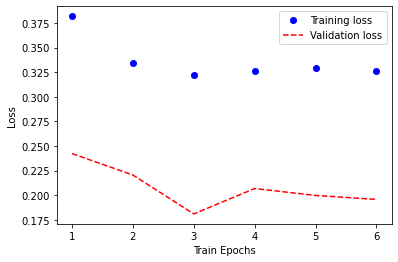

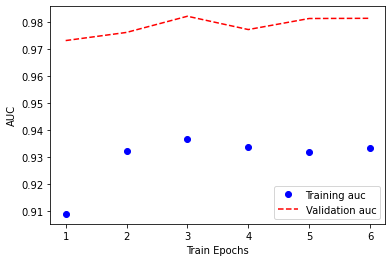

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

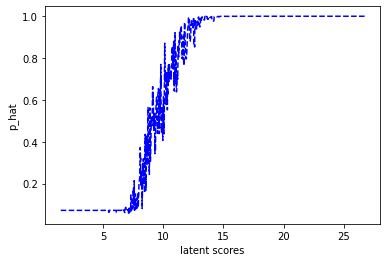

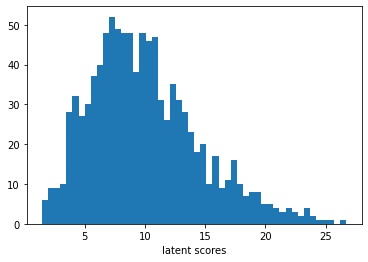

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

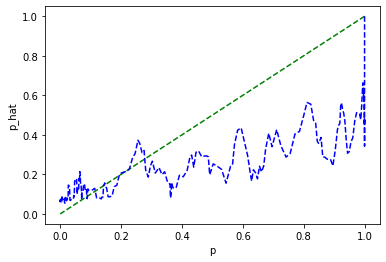

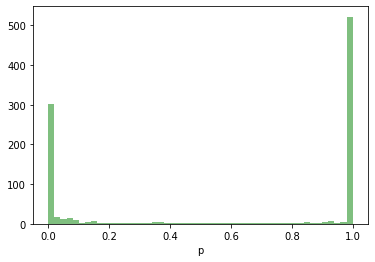

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

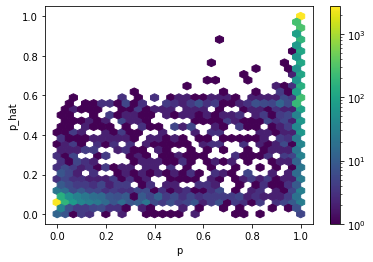

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

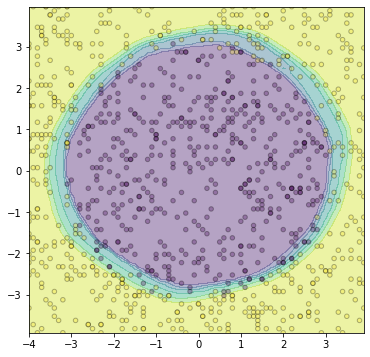

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.004,
 'batch': 8,
 'epoch': 3,
 'optimizer': 'rmsprop',
 'best_loss': {'loss': 0.18433214724063873, 'epoch': 6},
 'best_auc': {'auc': 0.9812194108963013, 'epoch': 6},
 'best_accuracy': {'accuracy': 0.9223499894142151, 'epoch': 5},
 'model': <keras.engine.sequential.Sequential at 0x7fc0c3642ca0>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.2702763080596924, 'epoch': 114},
  'best_auc': {'auc': 0.9896680116653442, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.8899499773979187, 'epoch': 70}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.2595530152320862, 'epoch': 80},
  'best_auc': {'auc': 0.9906519651412964, 'epoch': 117},
  'best_accuracy': {'accuracy': 0.8931000232696533, 'epoch': 49}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.2644463777542114, 'epoch': 71},
  'best_auc': {'auc': 0.9907048940658569, 'epoch': 117},
  'best_accuracy': {'accuracy': 0.8962500095367432, 'epoch': 38}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 177,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.25249114632606506, 'epoch': 182},
  'best_auc': {'auc': 0.9918808937072754, 'epoch': 249},
  'best_a

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25